In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.io import wavfile

In [14]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    return butter(order, normal_cutoff, btype='low', analog=False)

In [15]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    return butter(order, normal_cutoff, btype='high', analog=False)

In [16]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='band')

In [17]:
def butter_bandstop(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    return butter(order, [low, high], btype='stop')

In [18]:
def apply_filter(data, fs, filter_type, lowcut=None, highcut=None, order=5):
    if filter_type == "BPF":
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    elif filter_type == "HPF":
        b, a = butter_highpass(lowcut, fs, order=order)
    elif filter_type == "LPF":
        b, a = butter_lowpass(highcut, fs, order=order)
    elif filter_type == "BSF":
        b, a = butter_bandstop(lowcut, highcut, fs, order=order)
    else:
        raise ValueError("Invalid filter type")
    
    y = lfilter(b, a, data)
    return y

In [19]:
def plot_signal(time, data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(time, data, label=title)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_4960\1064114443.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read('../media/sample.wav')


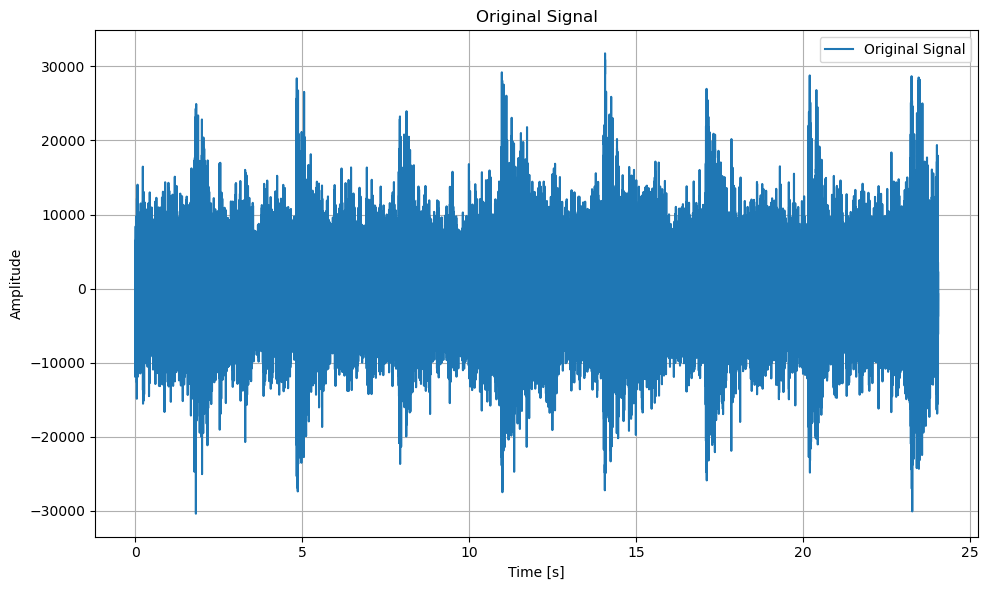

In [20]:
fs, data = wavfile.read('../media/sample.wav')

# Create a time axis based on sample rate and length of the signal
time = np.linspace(0, len(data)/fs, num=len(data))

# Plot original signal
plot_signal(time, data, "Original Signal")

In [21]:
lowcut = 500.0
highcut = 1500.0

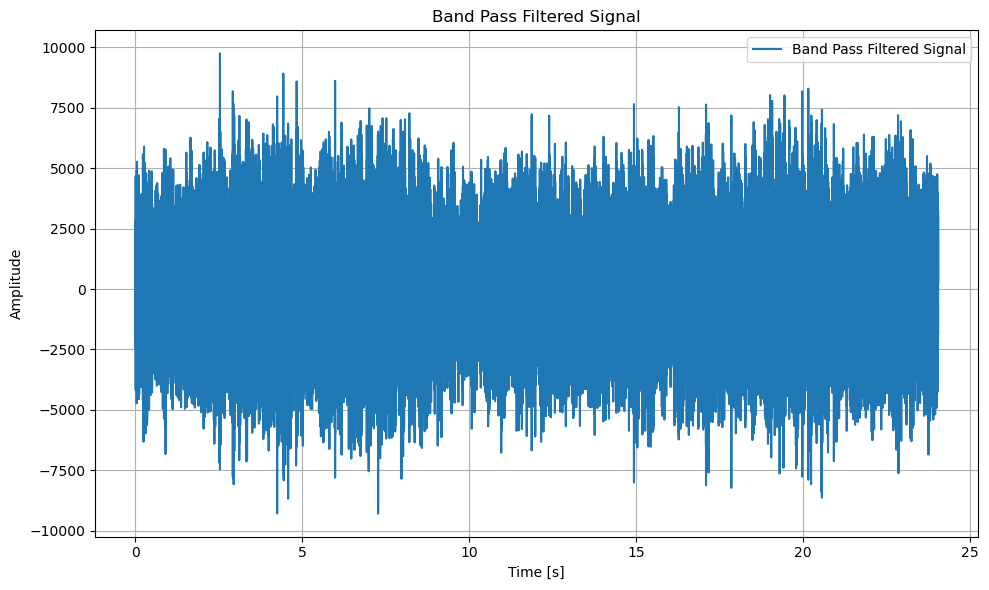

In [22]:
# Apply BPF
data_bpf = apply_filter(data, fs, "BPF", lowcut, highcut)
plot_signal(time, data_bpf, "Band Pass Filtered Signal")

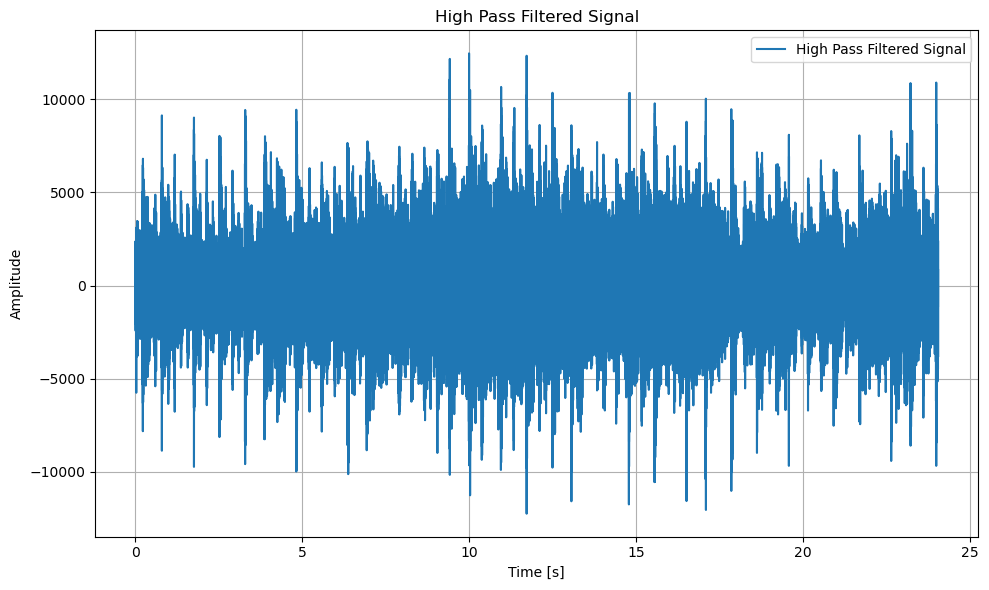

In [23]:
# Apply HPF
data_hpf = apply_filter(data, fs, "HPF", lowcut=highcut)
plot_signal(time, data_hpf, "High Pass Filtered Signal")

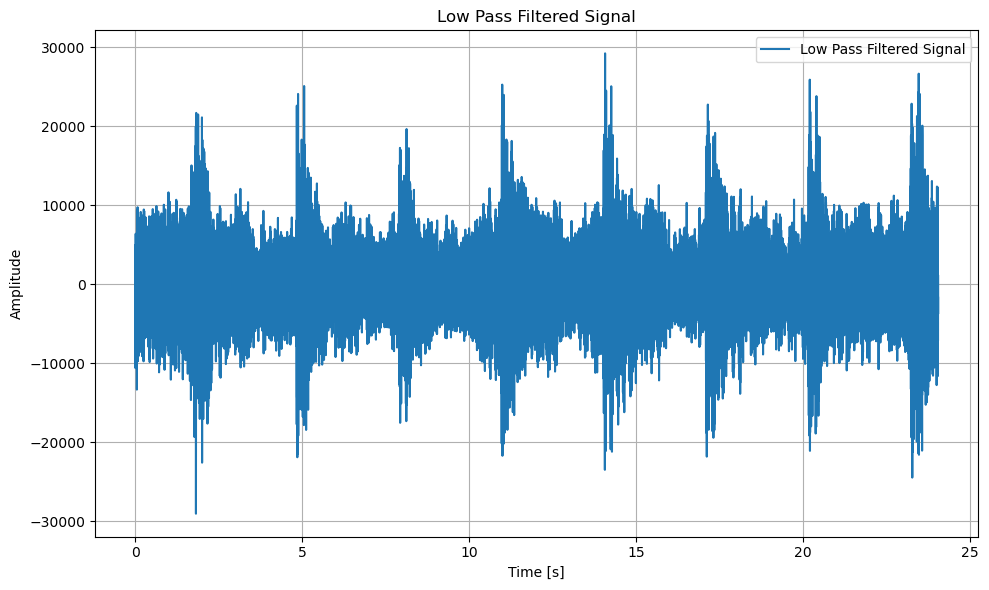

In [24]:
# Apply LPF
data_lpf = apply_filter(data, fs, "LPF", highcut=lowcut)
plot_signal(time, data_lpf, "Low Pass Filtered Signal")

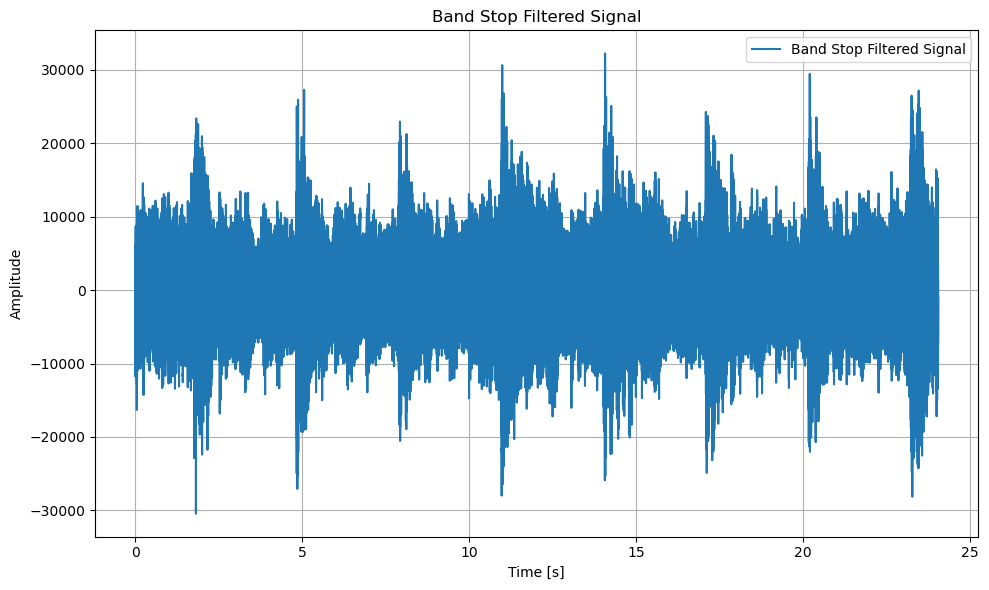

In [25]:
# Apply BSF
data_bsf = apply_filter(data, fs, "BSF", lowcut, highcut)
plot_signal(time, data_bsf, "Band Stop Filtered Signal")

In [26]:
# Save processed data to new .wav files
wavfile.write('../media/output_bpf.wav', fs, data_bpf.astype(np.int16))
wavfile.write('../media/output_hpf.wav', fs, data_hpf.astype(np.int16))
wavfile.write('../media/output_lpf.wav', fs, data_lpf.astype(np.int16))
wavfile.write('../media/output_bsf.wav', fs, data_bsf.astype(np.int16))